In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import seaborn as sns

c:\Users\cjong\Projects\education\kpmg2\KPMG_MTA_Data_Analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
#data = pd.read_csv('/content/Simplified All New Signals_weather holiday.csv')
data = pd.read_csv('../data/consolidated_signals.csv')
data['date'] = pd.to_datetime(data['date'])
start_date = '2020-04-20'
end_date = '2023-03-16'
data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
data.tail()

,date,ridership,barclays-center_event_occurred,blue-note-jazz-club_event_occurred,carnegie-hall_event_occurred,total_comedy,total_events,total_film-screenings,forest-hills-stadium_event_occurred,kings-theatre_event_occurred,...,metlife-stadium_event_occurred,total_music,radio-city-music-hall_event_occurred,terminal-5_event_occurred,the-bowery-ballroom_event_occurred,yankee-stadium_event_occurred,nyc_holiday,weather,high_temp,low_temp
1104,2023-03-12,1773585.0,1,1,0,21.0,134.0,3,0,1,...,0,55.0,0,0,1,0,0,Broken clouds,46,37
1105,2023-03-13,3352388.0,0,1,0,12.0,70.0,1,0,1,...,0,31.0,0,1,1,0,0,Light intensity drizzle,43,41
1106,2023-03-14,3577250.0,1,1,0,12.0,80.0,0,0,1,...,0,41.0,0,0,1,0,0,Snow,36,39
1107,2023-03-15,3912366.0,0,1,1,21.0,116.0,0,0,0,...,0,31.0,1,1,0,0,0,Few clouds,43,34
1108,2023-03-16,3949788.0,1,1,0,18.0,123.0,1,0,0,...,0,39.0,1,1,1,0,0,Few clouds,54,34


In [3]:
data = pd.get_dummies(data, prefix=['weather'], columns=['weather'])
data

,date,ridership,barclays-center_event_occurred,blue-note-jazz-club_event_occurred,carnegie-hall_event_occurred,total_comedy,total_events,total_film-screenings,forest-hills-stadium_event_occurred,kings-theatre_event_occurred,...,weather_Light rain,weather_Moderate rain,weather_Overcast clouds,weather_Partly clear and wet snow at times,weather_Partly cloudy,weather_Rain and snow,weather_Shower sleet,weather_Snow,weather_Thunderstorm with heavy rain,weather_Thunderstorm with rain
50,2020-04-20,437852.0,0,1,0,12.0,117.0,51,0,0,...,False,False,True,False,False,False,False,False,False,False
51,2020-04-21,422107.0,0,1,0,12.0,111.0,24,0,0,...,False,True,False,False,False,False,False,False,False,False
52,2020-04-22,458781.0,0,1,0,8.0,107.0,32,0,0,...,False,False,False,False,False,False,False,False,False,False
53,2020-04-23,453520.0,0,1,0,6.0,133.0,40,0,1,...,False,False,False,False,False,False,False,False,False,False
54,2020-04-24,443956.0,0,1,0,6.0,155.0,11,0,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1104,2023-03-12,1773585.0,1,1,0,21.0,134.0,3,0,1,...,False,False,False,False,False,False,False,False,False,False
1105,2023-03-13,3352388.0,0,1,0,12.0,70.0,1,0,1,...,False,False,False,False,False,False,False,False,False,False
1106,2023-03-14,3577250.0,1,1,0,12.0,80.0,0,0,1,...,False,False,False,False,False,False,False,True,False,False
1107,2023-03-15,3912366.0,0,1,1,21.0,116.0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


In [4]:
#rename for prophet requirement
data = data.rename(columns={"date": "ds", "ridership": "y"})

In [5]:
data.columns

Index(['ds', 'y', 'barclays-center_event_occurred',
       'blue-note-jazz-club_event_occurred', 'carnegie-hall_event_occurred',
       'total_comedy', 'total_events', 'total_film-screenings',
       'forest-hills-stadium_event_occurred', 'kings-theatre_event_occurred',
       'madison-square-garden_event_occurred',
       'metlife-stadium_event_occurred', 'total_music',
       'radio-city-music-hall_event_occurred', 'terminal-5_event_occurred',
       'the-bowery-ballroom_event_occurred', 'yankee-stadium_event_occurred',
       'nyc_holiday', 'high_temp', 'low_temp', 'weather_Broken clouds',
       'weather_Clear sky', 'weather_Cloudy and light snow', 'weather_Drizzle',
       'weather_Few clouds', 'weather_Heavy intensity rain',
       'weather_Heavy rain in places', 'weather_Heavy snow',
       'weather_Light intensity drizzle',
       'weather_Light intensity shower rain', 'weather_Light rain',
       'weather_Moderate rain', 'weather_Overcast clouds',
       'weather_Partly clear 

In [6]:
data

,ds,y,barclays-center_event_occurred,blue-note-jazz-club_event_occurred,carnegie-hall_event_occurred,total_comedy,total_events,total_film-screenings,forest-hills-stadium_event_occurred,kings-theatre_event_occurred,...,weather_Light rain,weather_Moderate rain,weather_Overcast clouds,weather_Partly clear and wet snow at times,weather_Partly cloudy,weather_Rain and snow,weather_Shower sleet,weather_Snow,weather_Thunderstorm with heavy rain,weather_Thunderstorm with rain
50,2020-04-20,437852.0,0,1,0,12.0,117.0,51,0,0,...,False,False,True,False,False,False,False,False,False,False
51,2020-04-21,422107.0,0,1,0,12.0,111.0,24,0,0,...,False,True,False,False,False,False,False,False,False,False
52,2020-04-22,458781.0,0,1,0,8.0,107.0,32,0,0,...,False,False,False,False,False,False,False,False,False,False
53,2020-04-23,453520.0,0,1,0,6.0,133.0,40,0,1,...,False,False,False,False,False,False,False,False,False,False
54,2020-04-24,443956.0,0,1,0,6.0,155.0,11,0,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1104,2023-03-12,1773585.0,1,1,0,21.0,134.0,3,0,1,...,False,False,False,False,False,False,False,False,False,False
1105,2023-03-13,3352388.0,0,1,0,12.0,70.0,1,0,1,...,False,False,False,False,False,False,False,False,False,False
1106,2023-03-14,3577250.0,1,1,0,12.0,80.0,0,0,1,...,False,False,False,False,False,False,False,True,False,False
1107,2023-03-15,3912366.0,0,1,1,21.0,116.0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


In [7]:
#check null values
print(data.isna().sum())

ds                                            0
y                                             0
barclays-center_event_occurred                0
blue-note-jazz-club_event_occurred            0
carnegie-hall_event_occurred                  0
total_comedy                                  0
total_events                                  0
total_film-screenings                         0
forest-hills-stadium_event_occurred           0
kings-theatre_event_occurred                  0
madison-square-garden_event_occurred          0
metlife-stadium_event_occurred                0
total_music                                   0
radio-city-music-hall_event_occurred          0
terminal-5_event_occurred                     0
the-bowery-ballroom_event_occurred            0
yankee-stadium_event_occurred                 0
nyc_holiday                                   0
high_temp                                     0
low_temp                                      0
weather_Broken clouds                   

In [8]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1059 entries, 50 to 1108
Data columns (total 40 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   ds                                          1059 non-null   datetime64[ns]
 1   y                                           1059 non-null   float64       
 2   barclays-center_event_occurred              1059 non-null   int64         
 3   blue-note-jazz-club_event_occurred          1059 non-null   int64         
 4   carnegie-hall_event_occurred                1059 non-null   int64         
 5   total_comedy                                1059 non-null   float64       
 6   total_events                                1059 non-null   float64       
 7   total_film-screenings                       1059 non-null   int64         
 8   forest-hills-stadium_event_occurred         1059 non-null   int64         
 9   kings-theatr

In [9]:
'''
fold1 = data[(data['ds'] >= start_date) & (data['ds'] <= "2020-09-25")]
fold2 = data[(data['ds'] >= start_date) & (data['ds'] <= "2021-03-24")]
fold3 = data[(data['ds'] >= start_date) & (data['ds'] <= "2021-09-20")]
fold4 = data[(data['ds'] >= start_date) & (data['ds'] <= "2022-03-19")]
fold5 = data[(data['ds'] >= start_date) & (data['ds'] <= "2022-09-15")]
fold6 = data[(data['ds'] >= start_date) & (data['ds'] <= "2023-03-02")]
'''

'\nfold1 = data[(data[\'ds\'] >= start_date) & (data[\'ds\'] <= "2020-09-25")]\nfold2 = data[(data[\'ds\'] >= start_date) & (data[\'ds\'] <= "2021-03-24")]\nfold3 = data[(data[\'ds\'] >= start_date) & (data[\'ds\'] <= "2021-09-20")]\nfold4 = data[(data[\'ds\'] >= start_date) & (data[\'ds\'] <= "2022-03-19")]\nfold5 = data[(data[\'ds\'] >= start_date) & (data[\'ds\'] <= "2022-09-15")]\nfold6 = data[(data[\'ds\'] >= start_date) & (data[\'ds\'] <= "2023-03-02")]\n'

In [10]:
data.tail()

,ds,y,barclays-center_event_occurred,blue-note-jazz-club_event_occurred,carnegie-hall_event_occurred,total_comedy,total_events,total_film-screenings,forest-hills-stadium_event_occurred,kings-theatre_event_occurred,...,weather_Light rain,weather_Moderate rain,weather_Overcast clouds,weather_Partly clear and wet snow at times,weather_Partly cloudy,weather_Rain and snow,weather_Shower sleet,weather_Snow,weather_Thunderstorm with heavy rain,weather_Thunderstorm with rain
1104,2023-03-12,1773585.0,1,1,0,21.0,134.0,3,0,1,...,False,False,False,False,False,False,False,False,False,False
1105,2023-03-13,3352388.0,0,1,0,12.0,70.0,1,0,1,...,False,False,False,False,False,False,False,False,False,False
1106,2023-03-14,3577250.0,1,1,0,12.0,80.0,0,0,1,...,False,False,False,False,False,False,False,True,False,False
1107,2023-03-15,3912366.0,0,1,1,21.0,116.0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1108,2023-03-16,3949788.0,1,1,0,18.0,123.0,1,0,0,...,False,False,False,False,False,False,False,False,False,False


In [11]:
fold1 = data[(data['ds'] >= start_date) & (data['ds'] <= "2020-09-11")]
fold2 = data[(data['ds'] >= start_date) & (data['ds'] <= "2021-03-10")]
fold3 = data[(data['ds'] >= start_date) & (data['ds'] <= "2021-09-06")]
fold4 = data[(data['ds'] >= start_date) & (data['ds'] <= "2022-03-05")]
fold5 = data[(data['ds'] >= start_date) & (data['ds'] <= "2022-09-01")]
fold6 = data[(data['ds'] >= start_date) & (data['ds'] <= "2023-02-16")]
fold7 = data[(data['ds'] >= "2022-02-01") & (data['ds'] <= "2023-03-02")]
testing = data[(data['ds'] >= "2023-03-03") & (data['ds'] <= "2023-03-16")]

In [12]:
fold7.columns

Index(['ds', 'y', 'barclays-center_event_occurred',
       'blue-note-jazz-club_event_occurred', 'carnegie-hall_event_occurred',
       'total_comedy', 'total_events', 'total_film-screenings',
       'forest-hills-stadium_event_occurred', 'kings-theatre_event_occurred',
       'madison-square-garden_event_occurred',
       'metlife-stadium_event_occurred', 'total_music',
       'radio-city-music-hall_event_occurred', 'terminal-5_event_occurred',
       'the-bowery-ballroom_event_occurred', 'yankee-stadium_event_occurred',
       'nyc_holiday', 'high_temp', 'low_temp', 'weather_Broken clouds',
       'weather_Clear sky', 'weather_Cloudy and light snow', 'weather_Drizzle',
       'weather_Few clouds', 'weather_Heavy intensity rain',
       'weather_Heavy rain in places', 'weather_Heavy snow',
       'weather_Light intensity drizzle',
       'weather_Light intensity shower rain', 'weather_Light rain',
       'weather_Moderate rain', 'weather_Overcast clouds',
       'weather_Partly clear 

# Event related high relevant sigals

In [13]:
event = fold7[['ds','y','total_comedy','total_events','total_film-screenings','total_music']]

In [14]:
m1 = Prophet()
for column in event.columns:
  if column !='ds' and column != 'y':
    m1.add_regressor(column)

m1.fit(event)
forecast1 = m1.predict(testing)

16:34:58 - cmdstanpy - INFO - Chain [1] start processing
16:34:58 - cmdstanpy - INFO - Chain [1] done processing


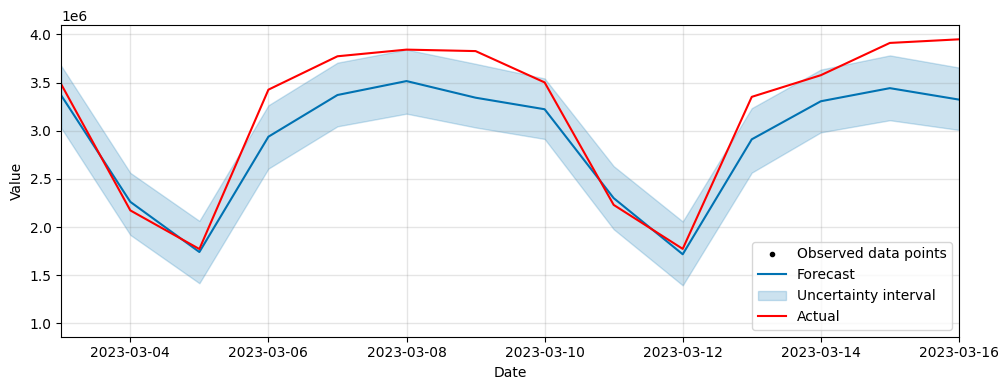

In [15]:
# plot only the forecast
fig = m1.plot(forecast1, xlabel='Date', ylabel='Value',figsize=(10,4))
fig.gca().set_xlim([testing['ds'].min(), testing['ds'].max()])
dates = testing['ds']
plt.plot(dates,testing['y'],label = 'Actual',color = 'red')

# display the plot
plt.legend()
plt.show()

In [16]:
test_data = testing
y_true = test_data['y'].values
y_pred1 = forecast1['yhat'].values
absolute_percentage_error = np.abs((y_true - y_pred1) / y_true)
mean_absolute_percentage_error = np.mean(absolute_percentage_error) * 100
mean_absolute_percentage_error

8.430584655155034

# Event and temp

In [17]:
eventemp = fold7[['ds','y','high_temp','low_temp','total_comedy','total_events','total_film-screenings','total_music']]

In [18]:
m2 = Prophet()
for column in eventemp.columns:
  if column !='ds' and column != 'y':
    m2.add_regressor(column)

m2.fit(eventemp)
forecast2 = m2.predict(testing)

16:34:59 - cmdstanpy - INFO - Chain [1] start processing
16:34:59 - cmdstanpy - INFO - Chain [1] done processing


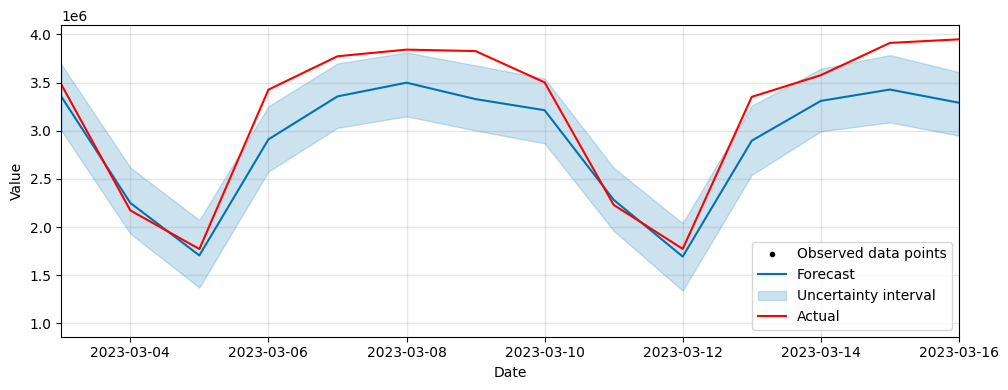

In [19]:
# plot only the forecast
fig = m2.plot(forecast2, xlabel='Date', ylabel='Value',figsize=(10,4))
fig.gca().set_xlim([testing['ds'].min(), testing['ds'].max()])
dates = testing['ds']
plt.plot(dates,testing['y'],label = 'Actual',color = 'red')

# display the plot
plt.legend()
plt.show()

In [20]:
test_data = testing
y_true = test_data['y'].values
y_pred1 = forecast2['yhat'].values
absolute_percentage_error = np.abs((y_true - y_pred1) / y_true)
mean_absolute_percentage_error = np.mean(absolute_percentage_error) * 100
mean_absolute_percentage_error

8.873016256721577

# using all signals

In [21]:
# Separate the data into training and testing sets
train_data = fold7
test_data = testing

# Initialize the Prophet model
m = Prophet()

# Add the regressors to the model for both training and testing sets
for column in fold7.columns:
    if column != 'ds' and column != 'y':
        m.add_regressor(column)

# Fit the model to the training set
m.fit(train_data)

# Make predictions for the testing set
#future = m.make_future_dataframe(periods=len(test_data))
forecast = m.predict(testing)

16:35:00 - cmdstanpy - INFO - Chain [1] start processing
16:35:00 - cmdstanpy - INFO - Chain [1] done processing


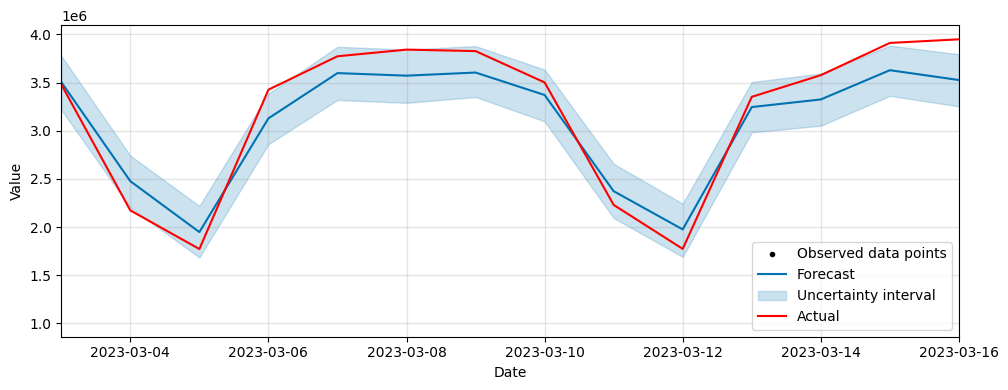

In [22]:
# plot only the forecast
fig = m.plot(forecast, xlabel='Date', ylabel='Value',figsize=(10,4))
fig.gca().set_xlim([testing['ds'].min(), testing['ds'].max()])
dates = testing['ds']
plt.plot(dates,testing['y'],label = 'Actual',color = 'red')

# display the plot
plt.legend()
plt.show()

In [23]:
y_true = test_data['y'].values
y_pred = forecast['yhat'].values
absolute_percentage_error = np.abs((y_true - y_pred) / y_true)
mean_absolute_percentage_error = np.mean(absolute_percentage_error) * 100
mean_absolute_percentage_error

7.1732743441148505

#grid search for fold 7

In [24]:
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 10],
    'seasonality_mode':['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(fold7)  # Fit model with given params
    forecast = m.predict(testing)
    score = np.mean(np.abs((testing['y'].values - forecast['yhat'].values)/testing['y'].values))*100
    mapes.append(score)

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
print(tuning_results)

16:35:00 - cmdstanpy - INFO - Chain [1] start processing
16:35:00 - cmdstanpy - INFO - Chain [1] done processing
16:35:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
16:35:00 - cmdstanpy - INFO - Chain [1] start processing
16:35:01 - cmdstanpy - INFO - Chain [1] done processing
16:35:01 - cmdstanpy - INFO - Chain [1] start processing
16:35:01 - cmdstanpy - INFO - Chain [1] done processing
16:35:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
16:35:01 - cmdstanpy - INFO - Chain [1] start processing
16:35:02 - cmdstanpy - INFO - Chain [1] done processing
16:35:02 - cmdstanpy - INFO - Chain [1] start processing
16:35:02 - cmdstanpy - INFO - Chain [1] done processing
16:35:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newto

    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale   
0                     0.001                     0.01                  0.01  \
1                     0.001                     0.01                  0.01   
2                     0.001                     0.01                 10.00   
3                     0.001                     0.01                 10.00   
4                     0.001                     0.10                  0.01   
..                      ...                      ...                   ...   
59                    0.500                     1.00                 10.00   
60                    0.500                    10.00                  0.01   
61                    0.500                    10.00                  0.01   
62                    0.500                    10.00                 10.00   
63                    0.500                    10.00                 10.00   

   seasonality_mode       mape  
0          additive  12.260087

In [25]:
tuning_results.sort_values('mape', ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,mape
31,0.010,10.00,10.00,multiplicative,4.276879
29,0.010,10.00,0.01,multiplicative,4.276879
27,0.010,1.00,10.00,multiplicative,4.292428
25,0.010,1.00,0.01,multiplicative,4.292428
9,0.001,1.00,0.01,multiplicative,4.378206
...,...,...,...,...,...
51,0.500,0.01,10.00,multiplicative,17.806844
3,0.001,0.01,10.00,multiplicative,17.883747
1,0.001,0.01,0.01,multiplicative,17.883747
35,0.100,0.01,10.00,multiplicative,18.041446


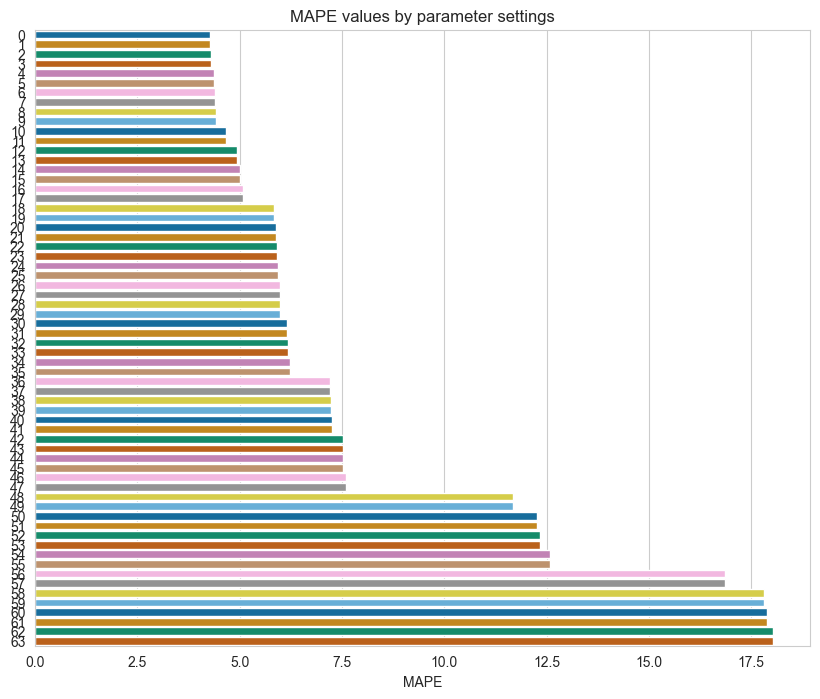

In [26]:
# Sort the dataframe by 'mape'
tuning_results_sorted = tuning_results.sort_values(by='mape',ascending =True).reset_index()

# Create a horizontal bar chart
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='mape', y=tuning_results_sorted.index, data=tuning_results_sorted, ax=ax, palette='colorblind',orient='h')

# Add labels and a title
ax.set_xlabel('MAPE')
ax.set_ylabel('')
ax.set_title('MAPE values by parameter settings')

# Show the plot
plt.show()

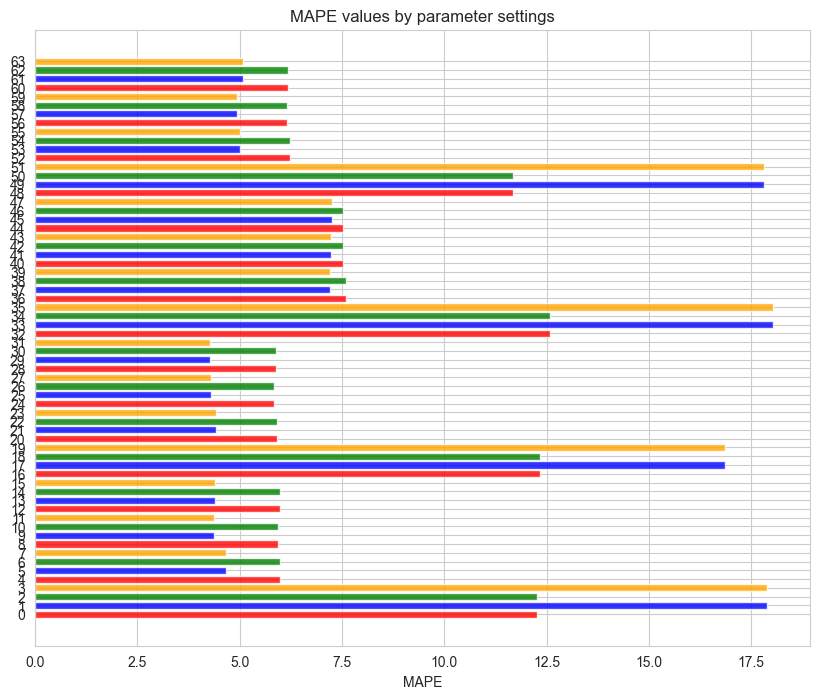

In [27]:
# Create a list of colors for the bars
colors = ['red', 'blue', 'green', 'orange']

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10,8))
y_pos = np.arange(len(tuning_results.index))
ax.barh(y_pos, tuning_results['mape'], color=colors, alpha=0.8)

# Add labels and a title
ax.set_yticks(y_pos)
ax.set_yticklabels(tuning_results.index)
ax.set_xlabel('MAPE')
ax.set_title('MAPE values by parameter settings')

# Show the plot
plt.show()

#grid search for events


In [28]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 10],
    'seasonality_mode':['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes1 = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m1 = Prophet(**params).fit(event)  # Fit model with given params
    forecast1 = m1.predict(testing)
    score1 = np.mean(np.abs((testing['y'].values - forecast1['yhat'].values)/testing['y'].values))*100
    mapes1.append(score1)

# Find the best parameters
tuning_results1 = pd.DataFrame(all_params)
tuning_results1['mape1'] = mapes1
print(tuning_results1)




param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 10],
    'seasonality_mode':['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(fold7)  # Fit model with given params
    forecast = m.predict(testing)
    score = np.mean(np.abs((testing['y'].values - forecast['yhat'].values)/testing['y'].values))*100
    mapes.append(score)

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
print(tuning_results)

16:35:21 - cmdstanpy - INFO - Chain [1] start processing
16:35:21 - cmdstanpy - INFO - Chain [1] done processing
16:35:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
16:35:21 - cmdstanpy - INFO - Chain [1] start processing
16:35:21 - cmdstanpy - INFO - Chain [1] done processing
16:35:21 - cmdstanpy - INFO - Chain [1] start processing
16:35:21 - cmdstanpy - INFO - Chain [1] done processing
16:35:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
16:35:21 - cmdstanpy - INFO - Chain [1] start processing
16:35:22 - cmdstanpy - INFO - Chain [1] done processing
16:35:22 - cmdstanpy - INFO - Chain [1] start processing
16:35:22 - cmdstanpy - INFO - Chain [1] done processing
16:35:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newto

    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale   
0                     0.001                     0.01                  0.01  \
1                     0.001                     0.01                  0.01   
2                     0.001                     0.01                 10.00   
3                     0.001                     0.01                 10.00   
4                     0.001                     0.10                  0.01   
..                      ...                      ...                   ...   
59                    0.500                     1.00                 10.00   
60                    0.500                    10.00                  0.01   
61                    0.500                    10.00                  0.01   
62                    0.500                    10.00                 10.00   
63                    0.500                    10.00                 10.00   

   seasonality_mode      mape1  
0          additive  12.260087

16:35:36 - cmdstanpy - INFO - Chain [1] done processing
16:35:36 - cmdstanpy - INFO - Chain [1] start processing
16:35:36 - cmdstanpy - INFO - Chain [1] done processing
16:35:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
16:35:36 - cmdstanpy - INFO - Chain [1] start processing
16:35:36 - cmdstanpy - INFO - Chain [1] done processing
16:35:37 - cmdstanpy - INFO - Chain [1] start processing
16:35:37 - cmdstanpy - INFO - Chain [1] done processing
16:35:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
16:35:37 - cmdstanpy - INFO - Chain [1] start processing
16:35:37 - cmdstanpy - INFO - Chain [1] done processing
16:35:37 - cmdstanpy - INFO - Chain [1] start processing
16:35:37 - cmdstanpy - INFO - Chain [1] done processing
16:35:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
O

    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale   
0                     0.001                     0.01                  0.01  \
1                     0.001                     0.01                  0.01   
2                     0.001                     0.01                 10.00   
3                     0.001                     0.01                 10.00   
4                     0.001                     0.10                  0.01   
..                      ...                      ...                   ...   
59                    0.500                     1.00                 10.00   
60                    0.500                    10.00                  0.01   
61                    0.500                    10.00                  0.01   
62                    0.500                    10.00                 10.00   
63                    0.500                    10.00                 10.00   

   seasonality_mode       mape  
0          additive  12.260087

In [29]:
forecast1

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2023-03-03,3.005740e+06,3.000205e+06,3.707013e+06,3.005740e+06,3.005740e+06,0.113855,0.113855,0.113855,0.113855,0.113855,0.113855,0.0,0.0,0.0,3.347958e+06
1,2023-03-04,3.007075e+06,1.883311e+06,2.564669e+06,3.007075e+06,3.007075e+06,-0.256741,-0.256741,-0.256741,-0.256741,-0.256741,-0.256741,0.0,0.0,0.0,2.235035e+06
2,2023-03-05,3.008410e+06,1.408774e+06,2.102229e+06,3.008410e+06,3.008410e+06,-0.415961,-0.415961,-0.415961,-0.415961,-0.415961,-0.415961,0.0,0.0,0.0,1.757027e+06
3,2023-03-06,3.009745e+06,2.708541e+06,3.396390e+06,3.009146e+06,3.009989e+06,0.014361,0.014361,0.014361,0.014361,0.014361,0.014361,0.0,0.0,0.0,3.052967e+06
4,2023-03-07,3.011080e+06,3.162272e+06,3.870623e+06,3.009498e+06,3.012135e+06,0.166719,0.166719,0.166719,0.166719,0.166719,0.166719,0.0,0.0,0.0,3.513085e+06
5,2023-03-08,3.012415e+06,3.254040e+06,3.946906e+06,3.009672e+06,3.014363e+06,0.195066,0.195066,0.195066,0.195066,0.195066,0.195066,0.0,0.0,0.0,3.600035e+06
6,2023-03-09,3.013750e+06,3.236539e+06,3.925104e+06,3.009885e+06,3.017053e+06,0.182702,0.182702,0.182702,0.182702,0.182702,0.182702,0.0,0.0,0.0,3.564367e+06
7,2023-03-10,3.015084e+06,3.008470e+06,3.690850e+06,3.009740e+06,3.020409e+06,0.113855,0.113855,0.113855,0.113855,0.113855,0.113855,0.0,0.0,0.0,3.358366e+06
8,2023-03-11,3.016419e+06,1.897197e+06,2.601537e+06,3.009627e+06,3.023323e+06,-0.256741,-0.256741,-0.256741,-0.256741,-0.256741,-0.256741,0.0,0.0,0.0,2.241980e+06
9,2023-03-12,3.017754e+06,1.423217e+06,2.107760e+06,3.009078e+06,3.026084e+06,-0.415961,-0.415961,-0.415961,-0.415961,-0.415961,-0.415961,0.0,0.0,0.0,1.762485e+06


In [30]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2023-03-03,3.005740e+06,2.988397e+06,3.679947e+06,3.005740e+06,3.005740e+06,0.113855,0.113855,0.113855,0.113855,0.113855,0.113855,0.0,0.0,0.0,3.347958e+06
1,2023-03-04,3.007075e+06,1.891843e+06,2.595937e+06,3.007075e+06,3.007075e+06,-0.256741,-0.256741,-0.256741,-0.256741,-0.256741,-0.256741,0.0,0.0,0.0,2.235035e+06
2,2023-03-05,3.008410e+06,1.413329e+06,2.093554e+06,3.008410e+06,3.008410e+06,-0.415961,-0.415961,-0.415961,-0.415961,-0.415961,-0.415961,0.0,0.0,0.0,1.757027e+06
3,2023-03-06,3.009745e+06,2.695877e+06,3.368356e+06,3.009161e+06,3.010735e+06,0.014361,0.014361,0.014361,0.014361,0.014361,0.014361,0.0,0.0,0.0,3.052967e+06
4,2023-03-07,3.011080e+06,3.153710e+06,3.859817e+06,3.009528e+06,3.013082e+06,0.166719,0.166719,0.166719,0.166719,0.166719,0.166719,0.0,0.0,0.0,3.513085e+06
5,2023-03-08,3.012415e+06,3.268430e+06,3.945642e+06,3.009807e+06,3.015344e+06,0.195066,0.195066,0.195066,0.195066,0.195066,0.195066,0.0,0.0,0.0,3.600035e+06
6,2023-03-09,3.013750e+06,3.233056e+06,3.897872e+06,3.009963e+06,3.017649e+06,0.182702,0.182702,0.182702,0.182702,0.182702,0.182702,0.0,0.0,0.0,3.564367e+06
7,2023-03-10,3.015084e+06,3.007203e+06,3.713078e+06,3.009896e+06,3.020420e+06,0.113855,0.113855,0.113855,0.113855,0.113855,0.113855,0.0,0.0,0.0,3.358366e+06
8,2023-03-11,3.016419e+06,1.903441e+06,2.578625e+06,3.009963e+06,3.023231e+06,-0.256741,-0.256741,-0.256741,-0.256741,-0.256741,-0.256741,0.0,0.0,0.0,2.241980e+06
9,2023-03-12,3.017754e+06,1.386223e+06,2.107843e+06,3.009479e+06,3.026487e+06,-0.415961,-0.415961,-0.415961,-0.415961,-0.415961,-0.415961,0.0,0.0,0.0,1.762485e+06


In [31]:
score1

5.080372017346239

In [32]:
tuning_results1.sort_values('mape1',ascending = True)

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,mape1
31,0.010,10.00,10.00,multiplicative,4.276879
29,0.010,10.00,0.01,multiplicative,4.276879
27,0.010,1.00,10.00,multiplicative,4.292428
25,0.010,1.00,0.01,multiplicative,4.292428
9,0.001,1.00,0.01,multiplicative,4.378206
...,...,...,...,...,...
51,0.500,0.01,10.00,multiplicative,17.806844
3,0.001,0.01,10.00,multiplicative,17.883747
1,0.001,0.01,0.01,multiplicative,17.883747
35,0.100,0.01,10.00,multiplicative,18.041446


In [33]:
mapes1

[12.260087080117364,
 17.883747488617765,
 12.260087080117364,
 17.883747488617765,
 5.987620430556548,
 4.67066977787737,
 5.987620430556548,
 4.67066977787737,
 5.942244575418347,
 4.378205999931422,
 5.942244575418347,
 4.378205999931422,
 5.9874036116582925,
 4.3861448530841045,
 5.9874036116582925,
 4.3861448530841045,
 12.347144006559962,
 16.851270322018827,
 12.347144006559962,
 16.851270322018827,
 5.912990940231723,
 4.409960746823211,
 5.912990940231723,
 4.409960746823211,
 5.83843835026905,
 4.292428102076866,
 5.83843835026905,
 4.292428102076866,
 5.874829034325893,
 4.276879035533511,
 5.874829034325893,
 4.276879035533511,
 12.592935837314373,
 18.041446322746072,
 12.592935837314373,
 18.041446322746072,
 7.585535029347968,
 7.210689537915278,
 7.585535029347968,
 7.210689537915278,
 7.527398086567576,
 7.2236847141863265,
 7.527398086567576,
 7.2236847141863265,
 7.515642011814308,
 7.262024719734668,
 7.515642011814308,
 7.262024719734668,
 11.678459643770337,
 17.8

In [34]:
mapes

[12.260087080117364,
 17.883747488617765,
 12.260087080117364,
 17.883747488617765,
 5.987620430556548,
 4.67066977787737,
 5.987620430556548,
 4.67066977787737,
 5.942244575418347,
 4.378205999931422,
 5.942244575418347,
 4.378205999931422,
 5.9874036116582925,
 4.3861448530841045,
 5.9874036116582925,
 4.3861448530841045,
 12.347144006559962,
 16.851270322018827,
 12.347144006559962,
 16.851270322018827,
 5.912990940231723,
 4.409960746823211,
 5.912990940231723,
 4.409960746823211,
 5.83843835026905,
 4.292428102076866,
 5.83843835026905,
 4.292428102076866,
 5.874829034325893,
 4.276879035533511,
 5.874829034325893,
 4.276879035533511,
 12.592935837314373,
 18.041446322746072,
 12.592935837314373,
 18.041446322746072,
 7.585535029347968,
 7.210689537915278,
 7.585535029347968,
 7.210689537915278,
 7.527398086567576,
 7.2236847141863265,
 7.527398086567576,
 7.2236847141863265,
 7.515642011814308,
 7.262024719734668,
 7.515642011814308,
 7.262024719734668,
 11.678459643770337,
 17.8

#grid search for events and temp

In [35]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 10],
    'seasonality_mode':['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes2 = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m2 = Prophet(**params).fit(eventemp)  # Fit model with given params
    forecast2 = m2.predict(testing)
    score2 = np.mean(np.abs((testing['y'].values - forecast2['yhat'].values)/testing['y'].values))*100
    mapes2.append(score2)

# Find the best parameters
tuning_results2 = pd.DataFrame(all_params)
tuning_results2['mape2'] = mapes2
print(tuning_results2)

16:35:50 - cmdstanpy - INFO - Chain [1] start processing
16:35:50 - cmdstanpy - INFO - Chain [1] done processing
16:35:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
16:35:51 - cmdstanpy - INFO - Chain [1] start processing
16:35:51 - cmdstanpy - INFO - Chain [1] done processing
16:35:51 - cmdstanpy - INFO - Chain [1] start processing
16:35:51 - cmdstanpy - INFO - Chain [1] done processing
16:35:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
16:35:51 - cmdstanpy - INFO - Chain [1] start processing
16:35:51 - cmdstanpy - INFO - Chain [1] done processing
16:35:52 - cmdstanpy - INFO - Chain [1] start processing
16:35:52 - cmdstanpy - INFO - Chain [1] done processing
16:35:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newto

    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale   
0                     0.001                     0.01                  0.01  \
1                     0.001                     0.01                  0.01   
2                     0.001                     0.01                 10.00   
3                     0.001                     0.01                 10.00   
4                     0.001                     0.10                  0.01   
..                      ...                      ...                   ...   
59                    0.500                     1.00                 10.00   
60                    0.500                    10.00                  0.01   
61                    0.500                    10.00                  0.01   
62                    0.500                    10.00                 10.00   
63                    0.500                    10.00                 10.00   

   seasonality_mode      mape2  
0          additive  12.260087

In [36]:
tuning_results2.sort_values('mape2',ascending = True)

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,mape2
31,0.010,10.00,10.00,multiplicative,4.276879
29,0.010,10.00,0.01,multiplicative,4.276879
27,0.010,1.00,10.00,multiplicative,4.292428
25,0.010,1.00,0.01,multiplicative,4.292428
9,0.001,1.00,0.01,multiplicative,4.378206
...,...,...,...,...,...
51,0.500,0.01,10.00,multiplicative,17.806844
3,0.001,0.01,10.00,multiplicative,17.883747
1,0.001,0.01,0.01,multiplicative,17.883747
35,0.100,0.01,10.00,multiplicative,18.041446


In [37]:
forecast = m.predict(testing)

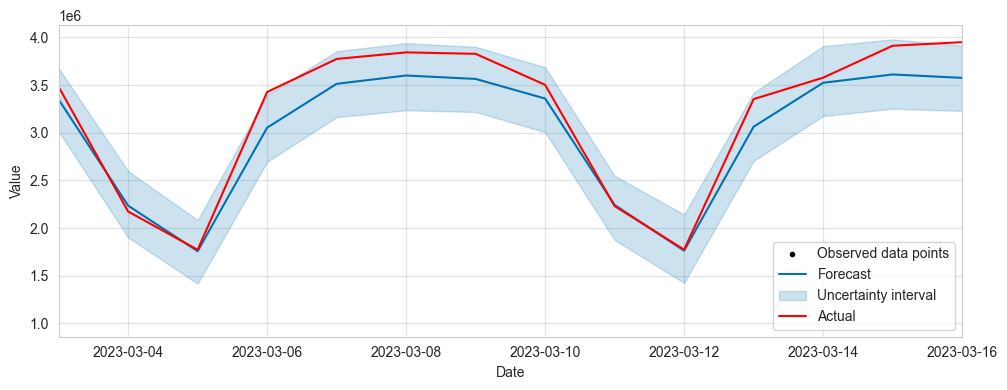

In [38]:
# plot only the forecast
fig = m.plot(forecast, xlabel='Date', ylabel='Value',figsize=(10,4))
fig.gca().set_xlim([testing['ds'].min(), testing['ds'].max()])
dates = testing['ds']
plt.plot(dates,testing['y'],label = 'Actual',color = 'red')

# display the plot
plt.legend()
plt.show()

In [39]:
y_true = test_data['y'].values
y_pred = forecast['yhat'].values
absolute_percentage_error = np.abs((y_true - y_pred) / y_true)
mean_absolute_percentage_error = np.mean(absolute_percentage_error) * 100
mean_absolute_percentage_error

5.080372017346239

# event 

# Fold 1

In [40]:
from sklearn.model_selection import ParameterGrid
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import pandas as pd

# Define parameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 1],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Load data
df = fold1

# Perform grid search CV
best_score = np.inf
for params in ParameterGrid(param_grid):
    model = Prophet(changepoint_prior_scale=params['changepoint_prior_scale'],
                    seasonality_mode=params['seasonality_mode'])
    model.fit(df)
    forecast = model.predict(df)
    score = mean_squared_error(forecast['yhat'], df['y'])
    if score < best_score:
        best_score = score
        best_params = params
    print (best_params)

# Fit final model with best hyperparameters
m = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'],
                      seasonality_mode=best_params['seasonality_mode'])
m.fit(df)



16:36:07 - cmdstanpy - INFO - Chain [1] start processing
16:36:07 - cmdstanpy - INFO - Chain [1] done processing
16:36:07 - cmdstanpy - INFO - Chain [1] start processing
16:36:07 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


16:36:07 - cmdstanpy - INFO - Chain [1] start processing
16:36:07 - cmdstanpy - INFO - Chain [1] done processing
16:36:07 - cmdstanpy - INFO - Chain [1] start processing
16:36:07 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


16:36:07 - cmdstanpy - INFO - Chain [1] start processing
16:36:08 - cmdstanpy - INFO - Chain [1] done processing
16:36:08 - cmdstanpy - INFO - Chain [1] start processing
16:36:08 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}
{'changepoint_prior_scale': 1, 'seasonality_mode': 'multiplicative'}


16:36:08 - cmdstanpy - INFO - Chain [1] start processing
16:36:08 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
validation_start = '2023-03-03'
validation_end = '2023-03-16'
validation_data = data[(data['ds'] >= validation_start) & (data['ds'] <= validation_end)]
validation_data = validation_data.reset_index()

In [42]:
validation_data

,index,ds,y,barclays-center_event_occurred,blue-note-jazz-club_event_occurred,carnegie-hall_event_occurred,total_comedy,total_events,total_film-screenings,forest-hills-stadium_event_occurred,...,weather_Light rain,weather_Moderate rain,weather_Overcast clouds,weather_Partly clear and wet snow at times,weather_Partly cloudy,weather_Rain and snow,weather_Shower sleet,weather_Snow,weather_Thunderstorm with heavy rain,weather_Thunderstorm with rain
0,1095,2023-03-03,3481830.0,0,1,0,33.0,197.0,15,0,...,False,False,True,False,False,False,False,False,False,False
1,1096,2023-03-04,2173217.0,1,1,0,35.0,216.0,24,0,...,False,False,True,False,False,False,False,False,False,False
2,1097,2023-03-05,1772121.0,1,1,0,19.0,146.0,7,0,...,False,False,False,False,False,False,False,False,False,False
3,1098,2023-03-06,3427019.0,0,1,0,12.0,76.0,5,0,...,False,False,False,False,False,False,False,False,False,False
4,1099,2023-03-07,3773780.0,1,1,0,18.0,98.0,0,0,...,False,False,False,False,False,False,False,False,False,False
5,1100,2023-03-08,3842861.0,1,1,0,14.0,129.0,0,0,...,False,False,False,False,False,False,False,False,False,False
6,1101,2023-03-09,3827656.0,1,1,0,18.0,129.0,8,0,...,False,False,False,False,False,False,False,False,False,False
7,1102,2023-03-10,3502339.0,0,1,0,17.0,157.0,4,0,...,False,False,True,False,False,False,False,False,False,False
8,1103,2023-03-11,2230530.0,1,1,0,40.0,212.0,12,0,...,False,False,False,False,False,False,False,False,False,False
9,1104,2023-03-12,1773585.0,1,1,0,21.0,134.0,3,0,...,False,False,False,False,False,False,False,False,False,False


In [43]:
forecast = m.predict(validation_data)

In [44]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2023-03-03,7.115037e+06,8.111009e+06,8.290357e+06,7.115037e+06,7.115037e+06,0.152715,0.152715,0.152715,0.152715,0.152715,0.152715,0.0,0.0,0.0,8.201609e+06
1,2023-03-04,7.121451e+06,5.002866e+06,5.177022e+06,7.121113e+06,7.121827e+06,-0.284748,-0.284748,-0.284748,-0.284748,-0.284748,-0.284748,0.0,0.0,0.0,5.093634e+06
2,2023-03-05,7.127866e+06,3.955606e+06,4.133174e+06,7.126904e+06,7.128958e+06,-0.432741,-0.432741,-0.432741,-0.432741,-0.432741,-0.432741,0.0,0.0,0.0,4.043346e+06
3,2023-03-06,7.134281e+06,7.567886e+06,7.747145e+06,7.132109e+06,7.136703e+06,0.073490,0.073490,0.073490,0.073490,0.073490,0.073490,0.0,0.0,0.0,7.658576e+06
4,2023-03-07,7.140696e+06,8.112716e+06,8.291525e+06,7.137218e+06,7.144478e+06,0.149043,0.149043,0.149043,0.149043,0.149043,0.149043,0.0,0.0,0.0,8.204969e+06
5,2023-03-08,7.147110e+06,8.291013e+06,8.473551e+06,7.142236e+06,7.152469e+06,0.172642,0.172642,0.172642,0.172642,0.172642,0.172642,0.0,0.0,0.0,8.381002e+06
6,2023-03-09,7.153525e+06,8.277635e+06,8.459089e+06,7.146871e+06,7.160747e+06,0.169599,0.169599,0.169599,0.169599,0.169599,0.169599,0.0,0.0,0.0,8.366754e+06
7,2023-03-10,7.159940e+06,8.165109e+06,8.341745e+06,7.151118e+06,7.169202e+06,0.152715,0.152715,0.152715,0.152715,0.152715,0.152715,0.0,0.0,0.0,8.253369e+06
8,2023-03-11,7.166354e+06,5.038891e+06,5.216164e+06,7.155693e+06,7.177466e+06,-0.284748,-0.284748,-0.284748,-0.284748,-0.284748,-0.284748,0.0,0.0,0.0,5.125750e+06
9,2023-03-12,7.172769e+06,3.980643e+06,4.163920e+06,7.159882e+06,7.185762e+06,-0.432741,-0.432741,-0.432741,-0.432741,-0.432741,-0.432741,0.0,0.0,0.0,4.068818e+06


In [45]:
forecast['actual'] = validation_data['y']

In [46]:
validation_data['y']

0     3481830.0
1     2173217.0
2     1772121.0
3     3427019.0
4     3773780.0
5     3842861.0
6     3827656.0
7     3502339.0
8     2230530.0
9     1773585.0
10    3352388.0
11    3577250.0
12    3912366.0
13    3949788.0
Name: y, dtype: float64

In [47]:
forecast['actual']

0     3481830.0
1     2173217.0
2     1772121.0
3     3427019.0
4     3773780.0
5     3842861.0
6     3827656.0
7     3502339.0
8     2230530.0
9     1773585.0
10    3352388.0
11    3577250.0
12    3912366.0
13    3949788.0
Name: actual, dtype: float64

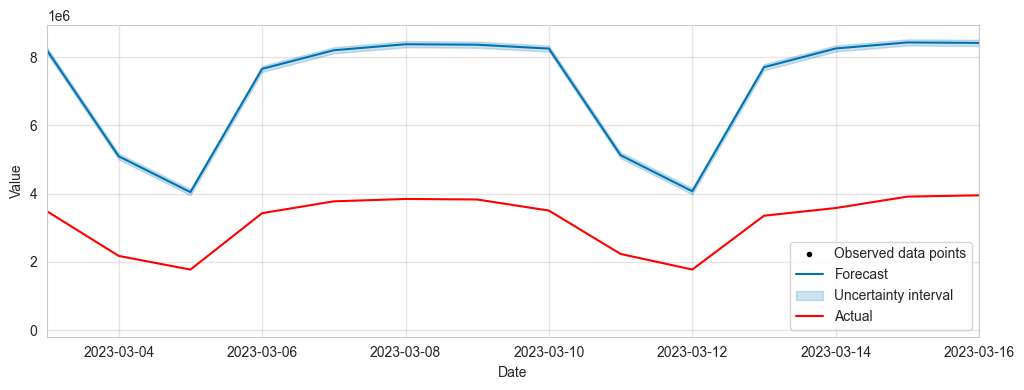

In [48]:
# plot only the forecast
fig = m.plot(forecast, xlabel='Date', ylabel='Value',figsize=(10,4))
fig.gca().set_xlim([validation_data['ds'].min(), validation_data['ds'].max()])
dates = validation_data['ds']
plt.plot(dates,validation_data['y'],label = 'Actual',color = 'red')

# display the plot
plt.legend()
plt.show()

In [49]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

#fold 1
ape = np.abs((forecast['actual'] - forecast['trend']) / forecast['trend'])
mape = np.mean(ape) * 100

print('MAPE: %.3f%%' % mape)

MAPE: 55.501%


#fold 2

In [50]:
from sklearn.model_selection import ParameterGrid
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import pandas as pd

# Define parameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 1],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Load data
df = fold2

# Perform grid search CV
best_score = np.inf
for params in ParameterGrid(param_grid):
    model = Prophet(changepoint_prior_scale=params['changepoint_prior_scale'],
                    seasonality_mode=params['seasonality_mode'])
    model.fit(df)
    forecast = model.predict(df)
    score = mean_squared_error(forecast['yhat'], df['y'])
    if score < best_score:
        best_score = score
        best_params = params

# Fit final model with best hyperparameters
m2 = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'],
                      seasonality_mode=best_params['seasonality_mode'])
m2.fit(df)



16:36:09 - cmdstanpy - INFO - Chain [1] start processing
16:36:09 - cmdstanpy - INFO - Chain [1] done processing
16:36:09 - cmdstanpy - INFO - Chain [1] start processing
16:36:09 - cmdstanpy - INFO - Chain [1] done processing
16:36:09 - cmdstanpy - INFO - Chain [1] start processing
16:36:09 - cmdstanpy - INFO - Chain [1] done processing
16:36:09 - cmdstanpy - INFO - Chain [1] start processing
16:36:09 - cmdstanpy - INFO - Chain [1] done processing
16:36:09 - cmdstanpy - INFO - Chain [1] start processing
16:36:09 - cmdstanpy - INFO - Chain [1] done processing
16:36:10 - cmdstanpy - INFO - Chain [1] start processing
16:36:10 - cmdstanpy - INFO - Chain [1] done processing
16:36:10 - cmdstanpy - INFO - Chain [1] start processing
16:36:10 - cmdstanpy - INFO - Chain [1] done processing


In [51]:
forecast2 = m2.predict(validation_data)
forecast2['actual'] = validation_data['y']

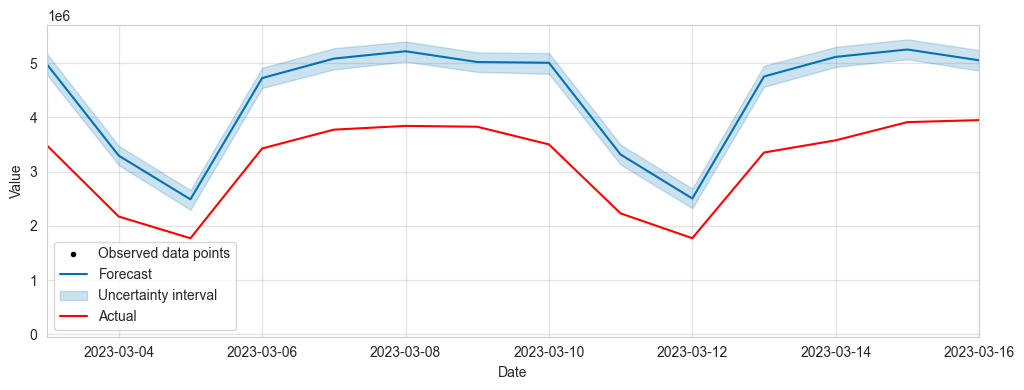

In [52]:
# plot only the forecast
fig = m2.plot(forecast2, xlabel='Date', ylabel='Value',figsize=(10,4))
fig.gca().set_xlim([validation_data['ds'].min(), validation_data['ds'].max()])
dates = validation_data['ds']
plt.plot(dates,validation_data['y'],label = 'Actual',color = 'red')

# display the plot
plt.legend()
plt.show()

In [53]:
#fold 2
ape = np.abs((forecast2['actual'] - forecast2['trend']) / forecast2['trend'])
mape = np.mean(ape) * 100

print('MAPE: %.3f%%' % mape)

MAPE: 27.846%


#fold 3

In [54]:
from sklearn.model_selection import ParameterGrid
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import pandas as pd

# Define parameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 1],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Load data
df = fold3

# Perform grid search CV
best_score = np.inf
for params in ParameterGrid(param_grid):
    model = Prophet(changepoint_prior_scale=params['changepoint_prior_scale'],
                    seasonality_mode=params['seasonality_mode'])
    model.fit(df)
    forecast = model.predict(df)
    score = mean_squared_error(forecast['yhat'], df['y'])
    if score < best_score:
        best_score = score
        best_params = params

# Fit final model with best hyperparameters
m3 = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'],
                      seasonality_mode=best_params['seasonality_mode'])
m3.fit(df)



16:36:10 - cmdstanpy - INFO - Chain [1] start processing
16:36:10 - cmdstanpy - INFO - Chain [1] done processing
16:36:11 - cmdstanpy - INFO - Chain [1] start processing
16:36:11 - cmdstanpy - INFO - Chain [1] done processing
16:36:11 - cmdstanpy - INFO - Chain [1] start processing
16:36:11 - cmdstanpy - INFO - Chain [1] done processing
16:36:11 - cmdstanpy - INFO - Chain [1] start processing
16:36:11 - cmdstanpy - INFO - Chain [1] done processing
16:36:11 - cmdstanpy - INFO - Chain [1] start processing
16:36:11 - cmdstanpy - INFO - Chain [1] done processing
16:36:11 - cmdstanpy - INFO - Chain [1] start processing
16:36:12 - cmdstanpy - INFO - Chain [1] done processing
16:36:12 - cmdstanpy - INFO - Chain [1] start processing
16:36:12 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
forecast3 = m3.predict(validation_data)
forecast3['actual'] = validation_data['y']

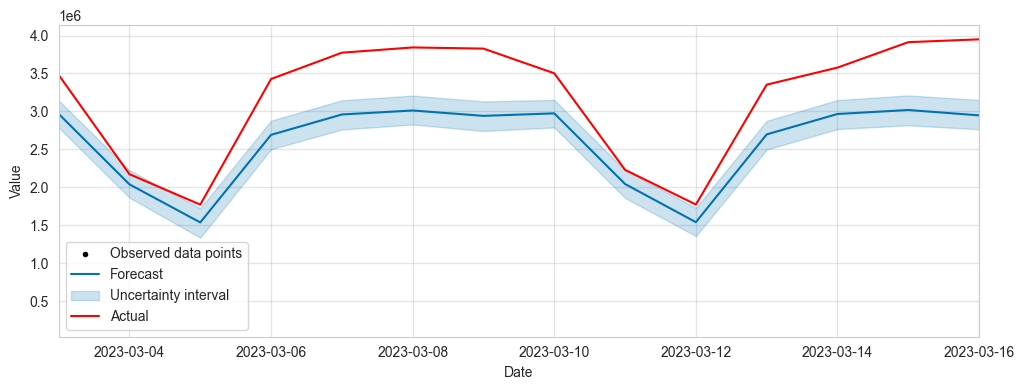

In [56]:
# plot only the forecast
fig = m3.plot(forecast3, xlabel='Date', ylabel='Value',figsize=(10,4))
fig.gca().set_xlim([validation_data['ds'].min(), validation_data['ds'].max()])
dates = validation_data['ds']
plt.plot(dates,validation_data['y'],label = 'Actual',color = 'red')

# display the plot
plt.legend()
plt.show()

In [57]:
#fold 3
ape = np.abs((forecast3['actual'] - forecast3['trend']) / forecast3['trend'])
mape = np.mean(ape) * 100

print('MAPE: %.3f%%' % mape)

MAPE: 36.085%


#fold 4

In [58]:
from sklearn.model_selection import ParameterGrid
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import pandas as pd

# Define parameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 1],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Load data
df = fold4

# Perform grid search CV
best_score = np.inf
for params in ParameterGrid(param_grid):
    model = Prophet(changepoint_prior_scale=params['changepoint_prior_scale'],
                    seasonality_mode=params['seasonality_mode'])
    model.fit(df)
    forecast = model.predict(df)
    score = mean_squared_error(forecast['yhat'], df['y'])
    if score < best_score:
        best_score = score
        best_params = params

# Fit final model with best hyperparameters
m4 = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'],
                      seasonality_mode=best_params['seasonality_mode'])
m4.fit(df)



16:36:12 - cmdstanpy - INFO - Chain [1] start processing
16:36:12 - cmdstanpy - INFO - Chain [1] done processing
16:36:13 - cmdstanpy - INFO - Chain [1] start processing
16:36:13 - cmdstanpy - INFO - Chain [1] done processing
16:36:13 - cmdstanpy - INFO - Chain [1] start processing
16:36:13 - cmdstanpy - INFO - Chain [1] done processing
16:36:13 - cmdstanpy - INFO - Chain [1] start processing
16:36:13 - cmdstanpy - INFO - Chain [1] done processing
16:36:13 - cmdstanpy - INFO - Chain [1] start processing
16:36:13 - cmdstanpy - INFO - Chain [1] done processing
16:36:14 - cmdstanpy - INFO - Chain [1] start processing
16:36:14 - cmdstanpy - INFO - Chain [1] done processing
16:36:14 - cmdstanpy - INFO - Chain [1] start processing
16:36:14 - cmdstanpy - INFO - Chain [1] done processing


In [59]:
forecast4 = m4.predict(validation_data)
forecast4['actual'] = validation_data['y']

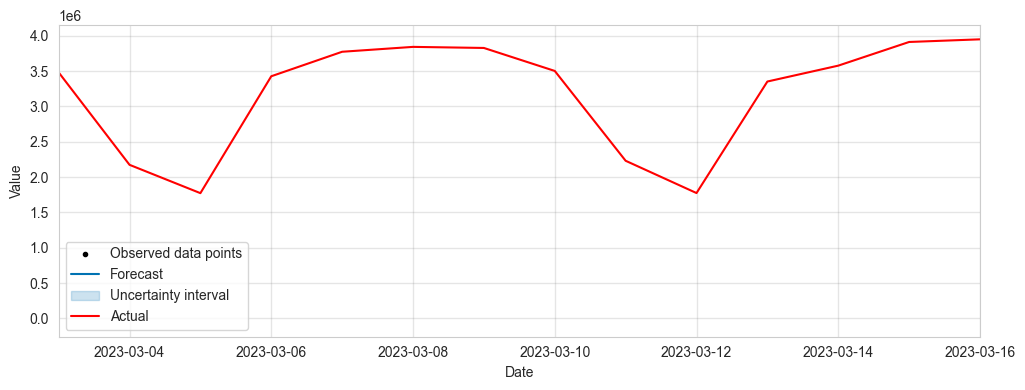

In [60]:
# plot only the forecast
fig = m4.plot(forecast, xlabel='Date', ylabel='Value',figsize=(10,4))
fig.gca().set_xlim([validation_data['ds'].min(), validation_data['ds'].max()])
dates = validation_data['ds']
plt.plot(dates,validation_data['y'],label = 'Actual',color = 'red')

# display the plot
plt.legend()
plt.show()

In [61]:
#fold 4
ape = np.abs((forecast4['actual'] - forecast4['trend']) / forecast4['trend'])
mape = np.mean(ape) * 100

print('MAPE: %.3f%%' % mape)

MAPE: 226.239%


#fold 5

In [62]:
from sklearn.model_selection import ParameterGrid
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import pandas as pd

# Define parameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 1],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Load data
df = fold5

# Perform grid search CV
best_score = np.inf
for params in ParameterGrid(param_grid):
    model = Prophet(changepoint_prior_scale=params['changepoint_prior_scale'],
                    seasonality_mode=params['seasonality_mode'])
    model.fit(df)
    forecast = model.predict(df)
    score = mean_squared_error(forecast['yhat'], df['y'])
    if score < best_score:
        best_score = score
        best_params = params

# Fit final model with best hyperparameters
m5 = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'],
                      seasonality_mode=best_params['seasonality_mode'])
m5.fit(df)



16:36:15 - cmdstanpy - INFO - Chain [1] start processing
16:36:15 - cmdstanpy - INFO - Chain [1] done processing
16:36:15 - cmdstanpy - INFO - Chain [1] start processing
16:36:15 - cmdstanpy - INFO - Chain [1] done processing
16:36:15 - cmdstanpy - INFO - Chain [1] start processing
16:36:16 - cmdstanpy - INFO - Chain [1] done processing
16:36:16 - cmdstanpy - INFO - Chain [1] start processing
16:36:16 - cmdstanpy - INFO - Chain [1] done processing
16:36:16 - cmdstanpy - INFO - Chain [1] start processing
16:36:16 - cmdstanpy - INFO - Chain [1] done processing
16:36:17 - cmdstanpy - INFO - Chain [1] start processing
16:36:17 - cmdstanpy - INFO - Chain [1] done processing
16:36:17 - cmdstanpy - INFO - Chain [1] start processing
16:36:17 - cmdstanpy - INFO - Chain [1] done processing


In [63]:
forecast5 = m5.predict(validation_data)
forecast5['actual'] = validation_data['y']

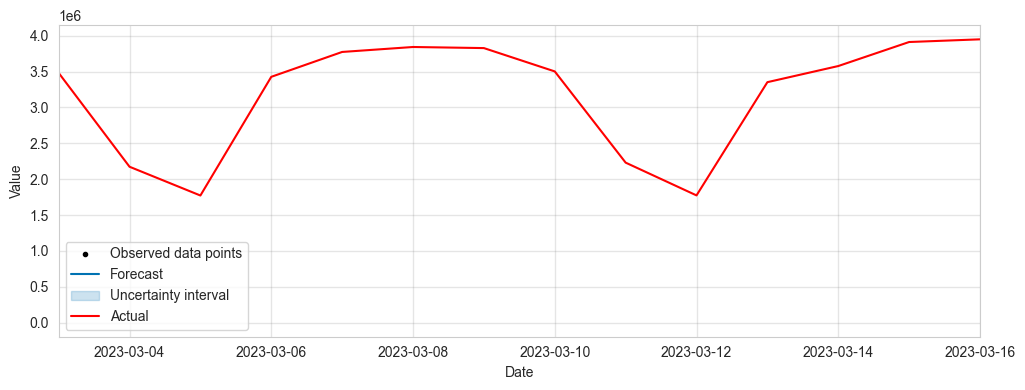

In [64]:
# plot only the forecast
fig = m5.plot(forecast, xlabel='Date', ylabel='Value',figsize=(10,4))
fig.gca().set_xlim([validation_data['ds'].min(), validation_data['ds'].max()])
dates = validation_data['ds']
plt.plot(dates,validation_data['y'],label = 'Actual',color = 'red')

# display the plot
plt.legend()
plt.show()

In [65]:
#fold 4
ape = np.abs((forecast5['actual'] - forecast5['trend']) / forecast5['trend'])
mape = np.mean(ape) * 100

print('MAPE: %.3f%%' % mape)

MAPE: 48.760%


#fold 6

In [66]:
from sklearn.model_selection import ParameterGrid
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import pandas as pd

# Define parameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 1],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Load data
df = fold6

# Perform grid search CV
best_score = np.inf
for params in ParameterGrid(param_grid):
    model = Prophet(changepoint_prior_scale=params['changepoint_prior_scale'],
                    seasonality_mode=params['seasonality_mode'])
    model.fit(df)
    forecast = model.predict(df)
    score = mean_squared_error(forecast['yhat'], df['y'])
    if score < best_score:
        best_score = score
        best_params = params

# Fit final model with best hyperparameters
m6 = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'],
                      seasonality_mode=best_params['seasonality_mode'])
m6.fit(df)



16:36:18 - cmdstanpy - INFO - Chain [1] start processing
16:36:18 - cmdstanpy - INFO - Chain [1] done processing
16:36:18 - cmdstanpy - INFO - Chain [1] start processing
16:36:18 - cmdstanpy - INFO - Chain [1] done processing
16:36:19 - cmdstanpy - INFO - Chain [1] start processing
16:36:19 - cmdstanpy - INFO - Chain [1] done processing
16:36:19 - cmdstanpy - INFO - Chain [1] start processing
16:36:19 - cmdstanpy - INFO - Chain [1] done processing
16:36:19 - cmdstanpy - INFO - Chain [1] start processing
16:36:20 - cmdstanpy - INFO - Chain [1] done processing
16:36:20 - cmdstanpy - INFO - Chain [1] start processing
16:36:20 - cmdstanpy - INFO - Chain [1] done processing
16:36:21 - cmdstanpy - INFO - Chain [1] start processing
16:36:21 - cmdstanpy - INFO - Chain [1] done processing


In [67]:
forecast6 = m6.predict(validation_data)
forecast6['actual'] = validation_data['y']

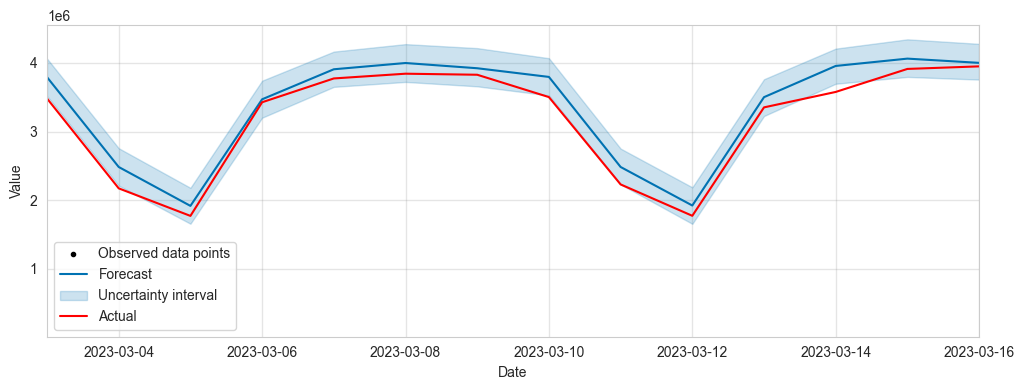

In [68]:
# plot only the forecast
fig = m6.plot(forecast6, xlabel='Date', ylabel='Value',figsize=(10,4))
fig.gca().set_xlim([validation_data['ds'].min(), validation_data['ds'].max()])
dates = validation_data['ds']
plt.plot(dates,validation_data['y'],label = 'Actual',color = 'red')

# display the plot
plt.legend()
plt.show()

In [69]:
#fold 6
ape = np.abs((forecast6['actual'] - forecast6['trend']) / forecast6['trend'])
mape = np.mean(ape) * 100

print('MAPE: %.3f%%' % mape)

MAPE: 16.449%


#fold 7

In [70]:
from sklearn.model_selection import ParameterGrid
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import pandas as pd

# Define parameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 1],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Load data
df = fold7

# Perform grid search CV
best_score = np.inf
for params in ParameterGrid(param_grid):
    model = Prophet(changepoint_prior_scale=params['changepoint_prior_scale'],
                    seasonality_mode=params['seasonality_mode'])
    model.fit(df)
    forecast = model.predict(df)
    score = mean_squared_error(forecast['yhat'], df['y'])
    if score < best_score:
        best_score = score
        best_params = params

# Fit final model with best hyperparameters
m7 = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'],
                      seasonality_mode=best_params['seasonality_mode'])
m7.fit(df)



16:36:22 - cmdstanpy - INFO - Chain [1] start processing
16:36:22 - cmdstanpy - INFO - Chain [1] done processing
16:36:22 - cmdstanpy - INFO - Chain [1] start processing
16:36:22 - cmdstanpy - INFO - Chain [1] done processing
16:36:22 - cmdstanpy - INFO - Chain [1] start processing
16:36:22 - cmdstanpy - INFO - Chain [1] done processing
16:36:22 - cmdstanpy - INFO - Chain [1] start processing
16:36:22 - cmdstanpy - INFO - Chain [1] done processing
16:36:22 - cmdstanpy - INFO - Chain [1] start processing
16:36:22 - cmdstanpy - INFO - Chain [1] done processing
16:36:23 - cmdstanpy - INFO - Chain [1] start processing
16:36:23 - cmdstanpy - INFO - Chain [1] done processing
16:36:23 - cmdstanpy - INFO - Chain [1] start processing
16:36:23 - cmdstanpy - INFO - Chain [1] done processing


In [71]:
forecast7 = m7.predict(validation_data)
forecast7['actual'] = validation_data['y']

In [72]:
validation_data

,index,ds,y,barclays-center_event_occurred,blue-note-jazz-club_event_occurred,carnegie-hall_event_occurred,total_comedy,total_events,total_film-screenings,forest-hills-stadium_event_occurred,...,weather_Light rain,weather_Moderate rain,weather_Overcast clouds,weather_Partly clear and wet snow at times,weather_Partly cloudy,weather_Rain and snow,weather_Shower sleet,weather_Snow,weather_Thunderstorm with heavy rain,weather_Thunderstorm with rain
0,1095,2023-03-03,3481830.0,0,1,0,33.0,197.0,15,0,...,False,False,True,False,False,False,False,False,False,False
1,1096,2023-03-04,2173217.0,1,1,0,35.0,216.0,24,0,...,False,False,True,False,False,False,False,False,False,False
2,1097,2023-03-05,1772121.0,1,1,0,19.0,146.0,7,0,...,False,False,False,False,False,False,False,False,False,False
3,1098,2023-03-06,3427019.0,0,1,0,12.0,76.0,5,0,...,False,False,False,False,False,False,False,False,False,False
4,1099,2023-03-07,3773780.0,1,1,0,18.0,98.0,0,0,...,False,False,False,False,False,False,False,False,False,False
5,1100,2023-03-08,3842861.0,1,1,0,14.0,129.0,0,0,...,False,False,False,False,False,False,False,False,False,False
6,1101,2023-03-09,3827656.0,1,1,0,18.0,129.0,8,0,...,False,False,False,False,False,False,False,False,False,False
7,1102,2023-03-10,3502339.0,0,1,0,17.0,157.0,4,0,...,False,False,True,False,False,False,False,False,False,False
8,1103,2023-03-11,2230530.0,1,1,0,40.0,212.0,12,0,...,False,False,False,False,False,False,False,False,False,False
9,1104,2023-03-12,1773585.0,1,1,0,21.0,134.0,3,0,...,False,False,False,False,False,False,False,False,False,False


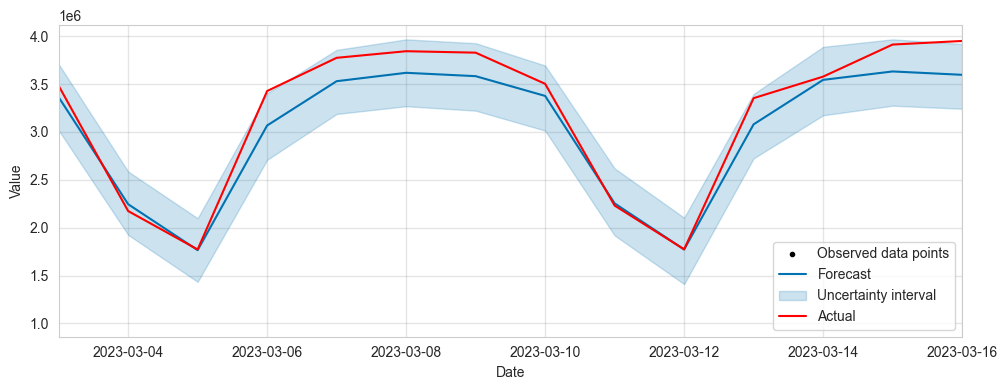

In [73]:
# plot only the forecast
fig = m7.plot(forecast7, xlabel='Date', ylabel='Value',figsize=(10,4))
fig.gca().set_xlim([validation_data['ds'].min(), validation_data['ds'].max()])
dates = validation_data['ds']
plt.plot(dates,validation_data['y'],label = 'Actual',color = 'red')

# display the plot
plt.legend()
plt.show()

In [74]:
#fold 7
ape = np.abs((forecast7['actual'] - forecast7['trend']) / forecast7['trend'])
mape = np.mean(ape) * 100

print('MAPE: %.3f%%' % mape)

MAPE: 24.756%


In [75]:
#fold 7
#multivariate modeling
m7 = Prophet()

# Add the regressors to the model
# assume that you have already defined the Prophet model m and have loaded the data into the DataFrame df
for column in fold4.columns:
    if column != 'ds' and column != 'y':
        m7.add_regressor(column)

# Fit the model
m7.fit(fold7)

16:36:23 - cmdstanpy - INFO - Chain [1] start processing
16:36:23 - cmdstanpy - INFO - Chain [1] done processing


In [76]:
forecast7 = m7.predict(validation_data)
forecast7['actual'] = validation_data['y']

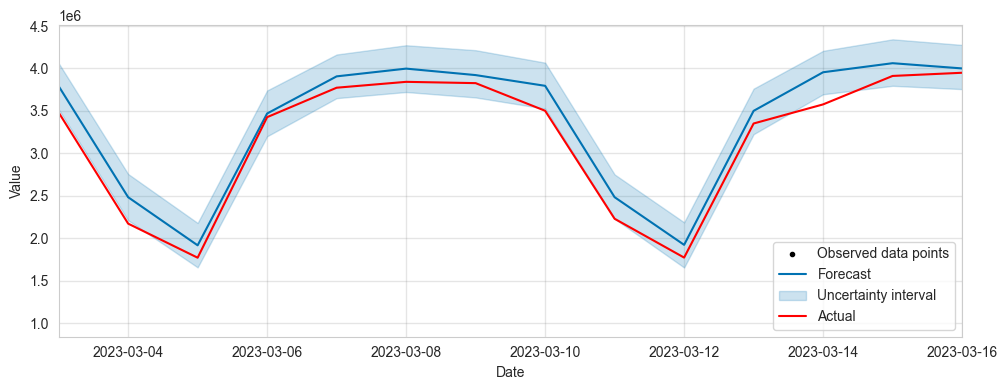

In [77]:
# plot only the forecast
fig = m7.plot(forecast6, xlabel='Date', ylabel='Value',figsize=(10,4))
fig.gca().set_xlim([validation_data['ds'].min(), validation_data['ds'].max()])
dates = validation_data['ds']
plt.plot(dates,validation_data['y'],label = 'Actual',color = 'red')

# display the plot
plt.legend()
plt.show()

In [78]:
#fold 7
ape = np.abs((forecast7['actual'] - forecast7['trend']) / forecast7['trend'])
mape = np.mean(ape) * 100

print('MAPE: %.3f%%' % mape)

MAPE: 23.353%
